In [40]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [41]:
if torch.cuda.is_available():
    DEVICE = torch.device('gpu')
else:
    DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [42]:
BATCH_SIZE = 32
EPOCHS = 10

In [47]:
train_data = datasets.CIFAR10(root = '../dataset/CIFAR10', 
                              train = True,
                              download= True, 
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),#50%확률로 좌우반전
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), #정규화 진행 (RGB)평균
                                (0.5, 0.5, 0.5))])) #정규화 진행 (RGB)표준편차
test_data = datasets.CIFAR10(root = '../dataset/CIFAR10', 
                              train = False,
                              download= True, 
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5))]))
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), 'type', x_train.type())
    print('y_train:', y_train.size(), 'type', y_train.type())
    break

x_train: torch.Size([32, 3, 32, 32]) type torch.FloatTensor
y_train: torch.Size([32]) type torch.LongTensor


In [11]:
for (x_test, y_test) in test_loader:
    print('x_test ', x_test.size(), 'type', x_test.type())
    print('y_test ', y_test.size(), 'type', y_test.type())
    break

x_test  torch.Size([32, 3, 32, 32]) type torch.FloatTensor
y_test  torch.Size([32]) type torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

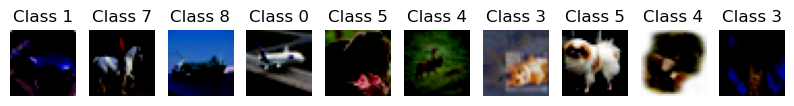

In [13]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i], (1, 2, 0))) 
    plt.title('Class ' + str(y_train[i].item()))

In [34]:
#ResNet 구현
#네트워크가 깊어짐에 따른 앞단의 layer에 대한 정보가 희석되는 단점을 보완 
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size = 3,
                               stride = stride,
                               padding = 1,#Zero padding
                               bias = False)#연산 진행 시 이미지 각 픽셀값, Filter의 파라미터 값, Convolution 연산 이후 Bias 값을 더 할지 선택
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 
                               kernel_size = 3,
                               stride = 1,
                               padding = 1,
                               bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes: #ResNet의 가장 큰 특징인 shortcut
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size = 1,
                          stride = stride,
                          bias = False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(out)#만약 in_planes이 planes와 다르거나 stride가 1이 아니라면 해당하는 값이 out에 반환되어 들어감
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 16,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride)) 
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out                

In [35]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track

In [36]:
def train(model, train_loader, optimizer, log_interval):
    model.train() #기존 정의 MLP모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader): #기존 정의된 train_loader의 이미지데이터와 Label을 불러오기
        image  = image.to(DEVICE) #미니배치 내에 있는 이미지 데이터를 기존 정의한 기기에 할당
        label = label.to(DEVICE) #미니배치 내에 있는 라벨링 데이터를 기존 정의한 기기에 할당
        optimizer.zero_grad() #과거에 이용한 미니 배치 내에 있는 이미지 데이터와 라벨 데이터에 저장된 가중치 초기화
        output = model(image) #순전파 과정
        loss = criterion(output, label) #기존 정의된 CrossEntropy를 통해 결과와 라벨 사이의 오차를 계산
        loss.backward() #역전파 과정 loss값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 가중치 할당
        optimizer.step() #각 파라미터별로 할당된 Gradient값을 이용하여 파라미터 값을 업데이트
        
        #학습현황과 train loss
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}  [{} / {} ({:0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [37]:
def evaluate(model, test_loader):
    model.eval() #모델을 평가상태로 지정
    test_loss = 0 #초기 loss
    correct = 0 #분류 성능확인을 위한 객체 초기값 지정
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image) #장비에 할당된 이미지를 학습
            test_loss += criterion(output, label).item() #기존 정의한 crossEntropy활용 loss값을 더해 없데이트
            prediction = output.max(1, keepdim = True)[1] # Output값의 크기가 10인 벡터값을 의미, 최대값으로 대응되는 값 도출
            correct += prediction.eq(label.view_as(prediction)).sum().item()#최종적으로 예측한 클래스값과 실제 클래스의 비교하고 합침
    test_loss /= len(test_loader.dataset) #현재 계산된 test_loss값을 test_loader내의 미니 배치 개수만큼 나눈 평균 loss를 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) #전체 미니 배치 개수 중 맞은 correct의 수
    return test_loss, test_accuracy

In [38]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH {}] \tTest_loss: {:.4f} \tTest_accuary: {:2f}%\n'.format(Epoch, test_loss, test_accuracy))
    

RuntimeError: Given groups=1, weight of size [16, 64, 3, 3], expected input[32, 16, 32, 32] to have 64 channels, but got 16 channels instead

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models

In [5]:
BATCH_SIZE = 32
EPOCHS = 10

In [19]:
if torch.cuda.is_available():
    DEVICE = torch.device('gpu')
else:
    DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [20]:
train_data = datasets.CIFAR10(root = '../dataset/CIFAR10', 
                              train = True,
                              download= True, 
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),#50%확률로 좌우반전
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), #정규화 진행 (RGB)평균
                                (0.5, 0.5, 0.5))])) #정규화 진행 (RGB)표준편차
test_data = datasets.CIFAR10(root = '../dataset/CIFAR10', 
                              train = False,
                              download= True, 
                              transform = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5))]))
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [22]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
def train(model, train_loader, optimizer, log_interval):
    model.train() #기존 정의 MLP모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader): #기존 정의된 train_loader의 이미지데이터와 Label을 불러오기
        image  = image.to(DEVICE) #미니배치 내에 있는 이미지 데이터를 기존 정의한 기기에 할당
        label = label.to(DEVICE) #미니배치 내에 있는 라벨링 데이터를 기존 정의한 기기에 할당
        optimizer.zero_grad() #과거에 이용한 미니 배치 내에 있는 이미지 데이터와 라벨 데이터에 저장된 가중치 초기화
        output = model(image) #순전파 과정
        loss = criterion(output, label) #기존 정의된 CrossEntropy를 통해 결과와 라벨 사이의 오차를 계산
        loss.backward() #역전파 과정 loss값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 가중치 할당
        optimizer.step() #각 파라미터별로 할당된 Gradient값을 이용하여 파라미터 값을 업데이트
        
        #학습현황과 train loss
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}  [{} / {} ({:0f}%)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [24]:
def evaluate(model, test_loader):
    model.eval() #모델을 평가상태로 지정
    test_loss = 0 #초기 loss
    correct = 0 #분류 성능확인을 위한 객체 초기값 지정
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image) #장비에 할당된 이미지를 학습
            test_loss += criterion(output, label).item() #기존 정의한 crossEntropy활용 loss값을 더해 없데이트
            prediction = output.max(1, keepdim = True)[1] # Output값의 크기가 10인 벡터값을 의미, 최대값으로 대응되는 값 도출
            correct += prediction.eq(label.view_as(prediction)).sum().item()#최종적으로 예측한 클래스값과 실제 클래스의 비교하고 합침
    test_loss /= len(test_loader.dataset) #현재 계산된 test_loss값을 test_loader내의 미니 배치 개수만큼 나눈 평균 loss를 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) #전체 미니 배치 개수 중 맞은 correct의 수
    return test_loss, test_accuracy

In [25]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH {}] \tTest_loss: {:.4f} \tTest_accuary: {:2f}%\n'.format(Epoch, test_loss, test_accuracy))
    

Train Epoch: 1  [0 / 50000 (0.000000%)]	Train Loss: 2.623733
Train Epoch: 1  [6400 / 50000 (12.795905%)]	Train Loss: 1.522679
Train Epoch: 1  [12800 / 50000 (25.591811%)]	Train Loss: 1.533237
Train Epoch: 1  [19200 / 50000 (38.387716%)]	Train Loss: 1.285312
Train Epoch: 1  [25600 / 50000 (51.183621%)]	Train Loss: 1.503734
Train Epoch: 1  [32000 / 50000 (63.979527%)]	Train Loss: 1.137163
Train Epoch: 1  [38400 / 50000 (76.775432%)]	Train Loss: 1.068770
Train Epoch: 1  [44800 / 50000 (89.571337%)]	Train Loss: 1.192781

[EPOCH 1] 	Test_loss: 0.0422 	Test_accuary: 49.980000%

Train Epoch: 2  [0 / 50000 (0.000000%)]	Train Loss: 1.213095
Train Epoch: 2  [6400 / 50000 (12.795905%)]	Train Loss: 1.544944
Train Epoch: 2  [12800 / 50000 (25.591811%)]	Train Loss: 0.979645
Train Epoch: 2  [19200 / 50000 (38.387716%)]	Train Loss: 1.198872
Train Epoch: 2  [25600 / 50000 (51.183621%)]	Train Loss: 1.181005
Train Epoch: 2  [32000 / 50000 (63.979527%)]	Train Loss: 0.886964
Train Epoch: 2  [38400 / 50000 